In [161]:
from docplex.mp.model import Model
import numpy as np
import random
import itertools
import random
import networkx as nx
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

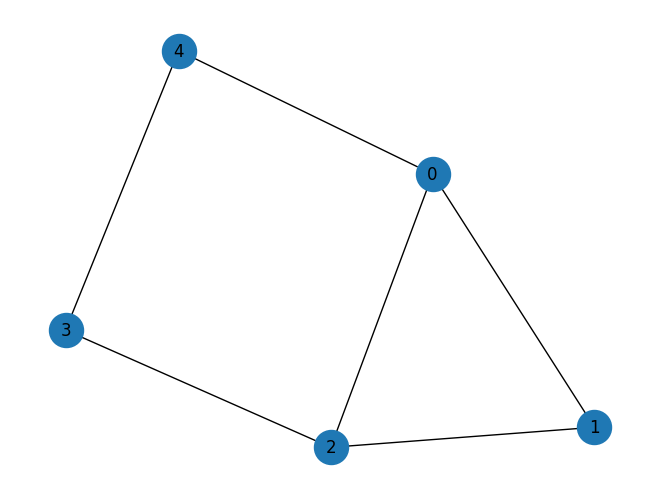

In [163]:
n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [165]:
def graph_to_qubo(graph):
    nodes = graph.node_indexes()  # Get node indices
    num_nodes = len(nodes)

    # Create a mapping from node labels to indices
    node_index = {node: i for i, node in enumerate(nodes)}

    # Initialize QUBO matrix
    Q = np.zeros((num_nodes, num_nodes))

    # Assign edge weights (-1) and ensure symmetry
    for u, v in graph.edge_list():
        i, j = node_index[u], node_index[v]  # Convert node labels to indices
        Q[i, j] = -1  # Interaction term
        Q[j, i] = -1  # Symmetric

    return Q
Q = graph_to_qubo(graph)

In [199]:
min_ = 1000
for i in range(2**n):
    x = [ii for ii in np.binary_repr(i,n)]
    # print(x)
    x = np.array([int(ii) for ii in x])
    if x.T @ Q @ x < min_:
        min_ = min(x.T @ Q @ x, min_)
        x_opt = x
print(min_,x_opt)

-12.0 [1 1 1 1 1]


In [169]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


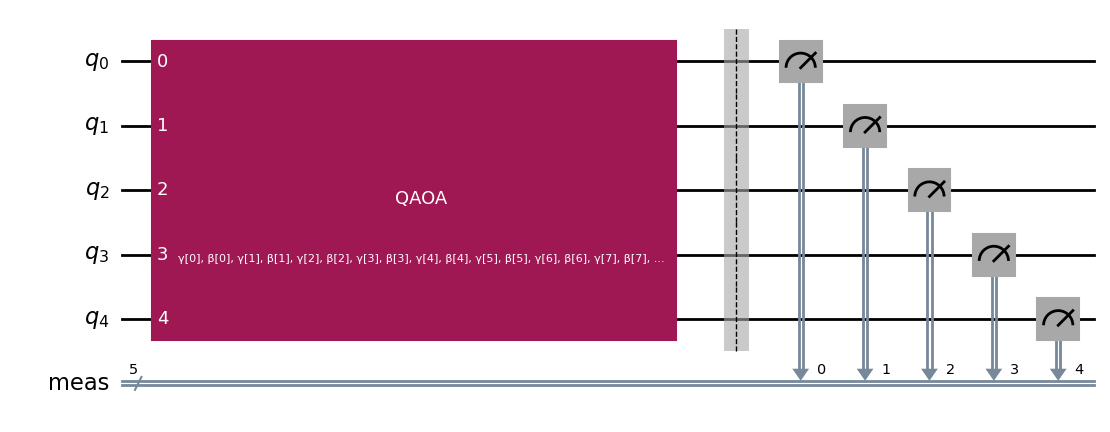

In [171]:
from qiskit.circuit.library import QAOAAnsatz
p = 10
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()

circuit.draw('mpl')

In [173]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(β[8]), ParameterVectorElement(β[9]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4]), ParameterVectorElement(γ[5]), ParameterVectorElement(γ[6]), ParameterVectorElement(γ[7]), ParameterVectorElement(γ[8]), ParameterVectorElement(γ[9])])

AerSimulator('aer_simulator')


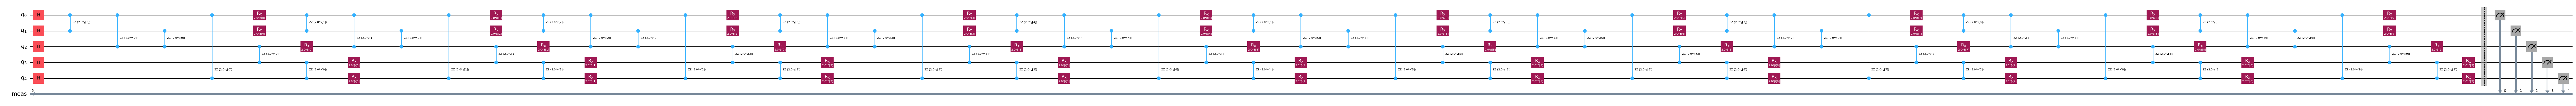

In [181]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

#IBMQ_TOKEN="b3e51fcce35ec269cc9c23eaca61b6a6907c8faa89560b11effa55543a26e938a724f549b2658657776884186e0914319e29ccd9172e58f37d32ff3ba3fe115a"
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=IBMQ_TOKEN, overwrite=True, set_as_default=True)
#service = QiskitRuntimeService(channel='ibm_quantum')
#backend = service.least_busy(min_num_qubits=127)
backend = AerSimulator()
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [182]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = np.random.rand(2*p)

In [185]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [187]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
#    estimator.options.dynamical_decoupling.enable = True
#    estimator.options.dynamical_decoupling.sequence_type = "XY4"
#    estimator.options.twirling.enable_gates = True
#    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.699300699300699
       x: [ 6.100e-01  1.939e+00 ...  4.125e-01  3.371e-01]
    nfev: 120
   maxcv: 0.0


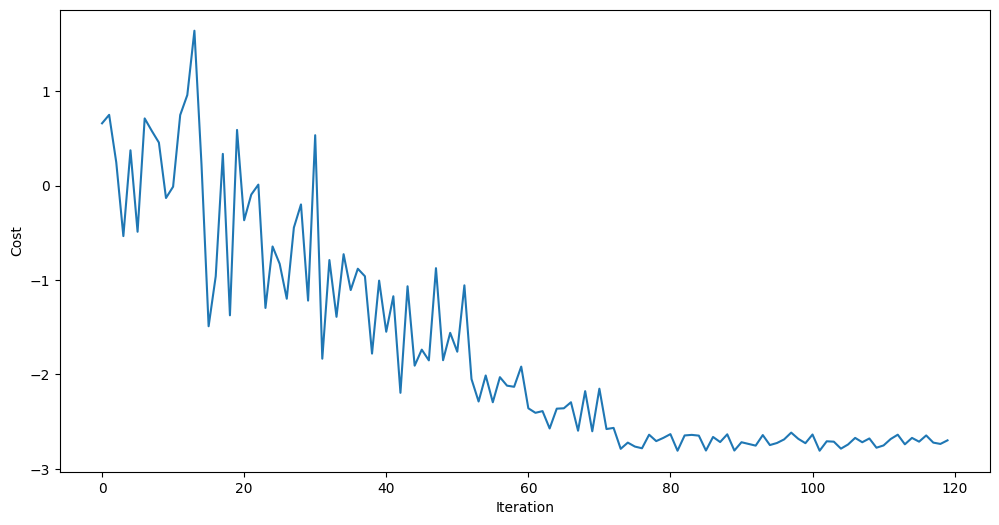

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

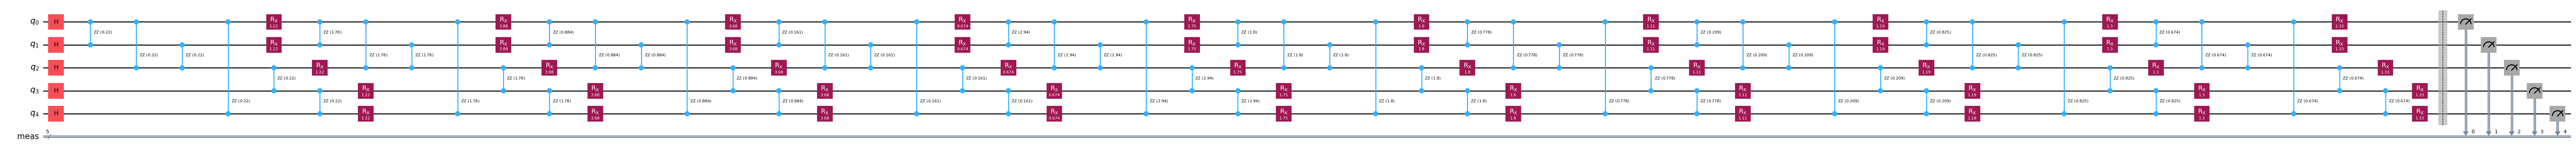

In [191]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [193]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.default_shots = 1024

# Set simple error suppression/mitigation options
#sampler.options.dynamical_decoupling.enable = True
#sampler.options.dynamical_decoupling.sequence_type = "XY4"
#sampler.options.twirling.enable_gates = True
#sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{20: 0.1311, 11: 0.1292, 9: 0.1244, 31: 0.0067, 13: 0.0743, 21: 0.076, 6: 0.017, 18: 0.0709, 22: 0.1315, 26: 0.0356, 28: 0.0178, 10: 0.0724, 17: 0.0038, 5: 0.0368, 25: 0.0193, 3: 0.0168, 29: 0.0047, 0: 0.0062, 19: 0.0051, 12: 0.0026, 23: 0.0008, 24: 0.0016, 1: 0.0003, 14: 0.0055, 7: 0.0018, 8: 0.0013, 4: 0.0003, 2: 0.0038, 15: 0.001, 30: 0.0002, 16: 0.0009, 27: 0.0003}


In [201]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)
print("brute force solution", x_opt)

if (x_opt == most_likely_bitstring).all():
    print("Both solutions are the same and correct.")
else:
    print("Solutions are different.")

Result bitstring: [0, 1, 1, 0, 1]
brute force solution [1 1 1 1 1]
Solutions are different.
